<a href="https://colab.research.google.com/github/Bork00/Machine_learning_boot/blob/main/Kalkulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Słownik

Wymagania do cyklu:
- Dowolny cykl mocy w czasie
- time step najlepiej 1s, w przeciwnym razie zmiany w RMS

Założenia:
- DoD -zakres rozładowywania ogniwa
- SOH_EOL - SOH na końcu życia baterii (End of Life)
- requiredBatteryPackNominalVoltage - oczekiwana wartośćnapięcia [V]

Z bazy ogniw:
- cellNominalVoltage - nominalne napięcie ogniwa odczytane z bazy danych [V]
- cellMinVoltage - minimalne napięcie ogniwa odczytane z bazy danych [V]
- cellMaxVoltage - maksymalne napięcie ogniwa odczytane z bazy danych [V]

Obliczane:
- Energy - energia wynikająca z cyklu pracy ogniwa [kWh]
- realBatteryPackNominalVoltage - napięcie jakie osiągnie bateria na tym ogniwie [V]
- minRequiredUsableEnergy - wartość energii użytecznej + 5% [kWh]
- minRequiredNominalEnergy - wartość energii nominalnej + 5% [kWh]
- maxRequiredUsableEnergy - wartość energii nominalnej + 20% [kWh]
- maxRequiredNominalEnergy - wartość energii nominalnej + 20% [kWh]

RMSy charge/discharge:
- podzielenie cyklu na ładowanie i rozładowanie


# Import

In [615]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Assumed values

In [616]:
requiredBatteryPackNominalVoltage = 650
assumedPackWidth = 500
assumedPackHeigh = 400
assumedPackLength = 2000
assumedPackDimension = {
    'Assumed pack length': assumedPackLength,
    'Assumed pack width': assumedPackWidth,
    'Assumed pack heigh': assumedPackHeigh
}

# Cycle

In [617]:
dataCycle = pd.read_excel('/content/drive/My Drive/Magister/full_cycle-prepered.xlsx')
cycle = dataCycle.copy()
cycle.head()

,Time [s],Power [kW]
0,0,-0.076853
1,1,-0.078633
2,2,-0.084972
3,3,-0.099347
4,4,-0.121616


<Axes: xlabel='Time [s]'>

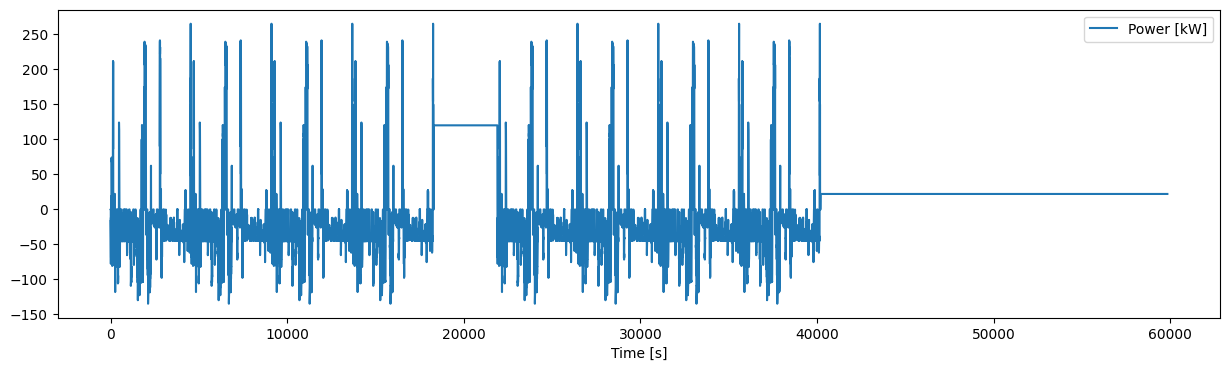

In [618]:
cycle.plot(x='Time [s]', y='Power [kW]', figsize=(15,4))

<Axes: xlabel='Time [s]'>

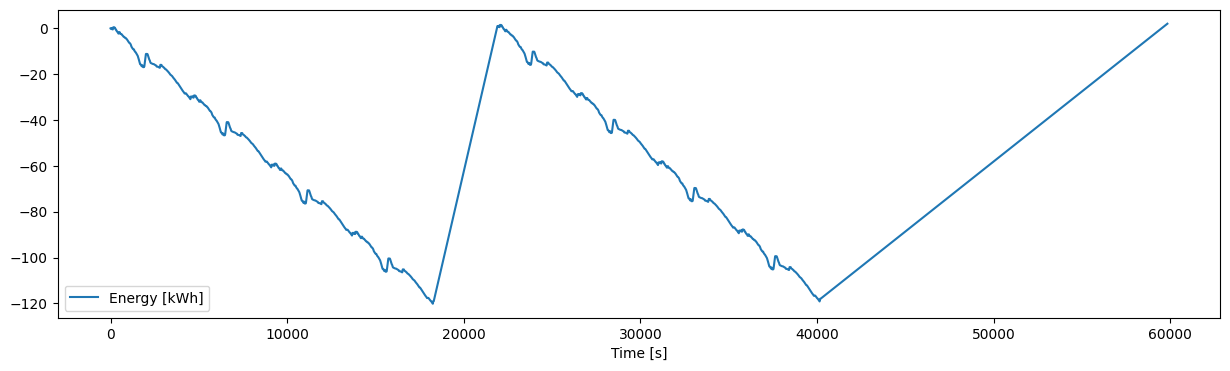

In [619]:
cycle['Energy [kWh]'] = (cycle['Power [kW]'].cumsum())/3600
cycle.plot(x='Time [s]', y='Energy [kWh]', figsize=(15,4))

# Assumed parameters calculation

In [620]:
calculatedParameters = {}

In [621]:
cycleUsableEnergyEOL = - cycle['Energy [kWh]'].min()
calculatedParameters['Cycle usable energy EOL [kWh]'] =  [cycleUsableEnergyEOL]
cycleUsableEnergyEOL

120.15619375267677

In [622]:
calculatedParameters['Max cycle usable energy EOL [kWh]'] =  [cycleUsableEnergyEOL * 1.3]

In [623]:
# stringConfiguration = ceil(requiredBatteryPackNominalVoltage/cellNominalVoltage) # wykorzystuję założoną wartość
# calculatedParameters['Configuration'] = [f'{stringConfiguration}S1P']
# stringConfiguration
calculatedParameters['Parallel configuration'] = np.nan

In [624]:
systemParametersDataFrame = pd.DataFrame(calculatedParameters, index = [0])
systemParametersDataFrame['System nominal voltage [V]'] = requiredBatteryPackNominalVoltage
systemParametersDataFrame

,Cycle usable energy EOL [kWh],Max cycle usable energy EOL [kWh],Parallel configuration,System nominal voltage [V]
0,120.156194,156.203052,NaN,650


#RMS analysis

## RMS Charge

In [625]:
cycle['Current [A]'] = cycle['Power [kW]'] / systemParametersDataFrame['System nominal voltage [V]'].iloc[0] * 1000

<Axes: xlabel='Time [s]'>

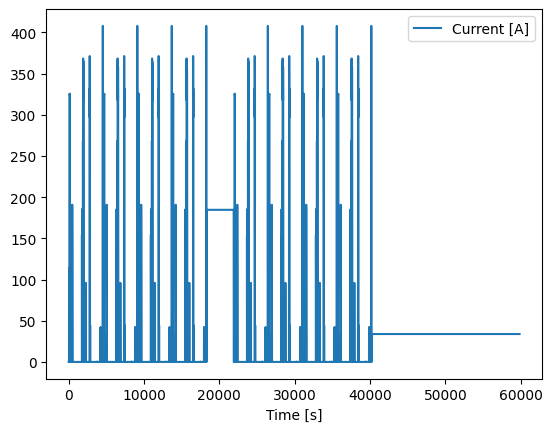

In [626]:
chargingCycle = cycle[['Time [s]', 'Current [A]']].copy()
chargingCycle['Current [A]'] = cycle['Current [A]'].where(cycle['Current [A]'] > 0).fillna(0)
chargingCycle.plot('Time [s]', 'Current [A]')

<Axes: xlabel='Time [s]'>

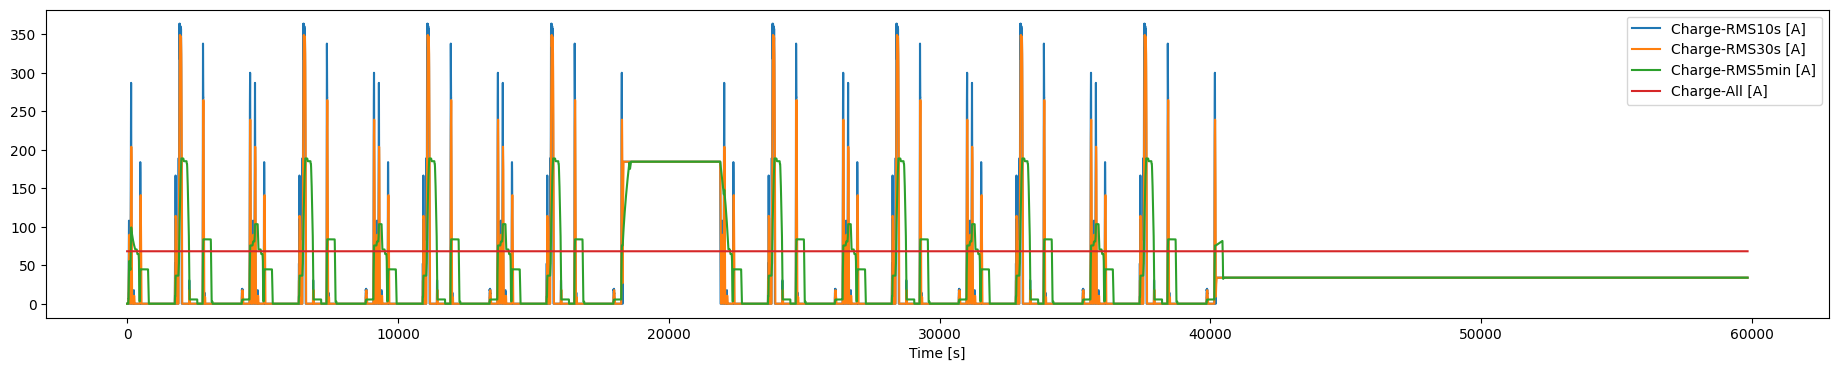

In [627]:
chargingCycle['Charge-RMS10s [A]'] = chargingCycle['Current [A]'].rolling(window=10, min_periods=1).apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)
chargingCycle['Charge-RMS30s [A]'] = chargingCycle['Current [A]'].rolling(window=30, min_periods=1).apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)
chargingCycle['Charge-RMS5min [A]'] = chargingCycle['Current [A]'].rolling(window=300, min_periods=1).apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)
chargingCycle['Charge-All [A]'] = np.sqrt((chargingCycle['Current [A]'] ** 2).mean())
chargingCycle.plot(x='Time [s]', y=['Charge-RMS10s [A]', 'Charge-RMS30s [A]','Charge-RMS5min [A]', 'Charge-All [A]'], figsize=(23, 4))

In [628]:
maxChargingRMS = chargingCycle[['Charge-RMS10s [A]','Charge-RMS30s [A]','Charge-RMS5min [A]','Charge-All [A]']].max().to_frame().T
maxChargingRMS

,Charge-RMS10s [A],Charge-RMS30s [A],Charge-RMS5min [A],Charge-All [A]
0,363.953855,349.331891,188.815069,68.189376


In [629]:
# columns = pd.MultiIndex.from_tuples([
#     ('Charge', 'RMS10s [A]'),
#     ('Charge', 'RMS30s [A]'),
#     ('Charge', 'RMS5min [A]'),
#     ('Charge', 'All [A]')
# ])
# data = chargingCycle[['Charge-RMS10s [A]','Charge-RMS30s [A]','Charge-RMS5min [A]','Charge-All [A]']].max().to_frame().T

# maxChargingRMS = pd.DataFrame(data= data.values, columns=columns)
# maxChargingRMS

## RMS Discharge

<Axes: xlabel='Time [s]'>

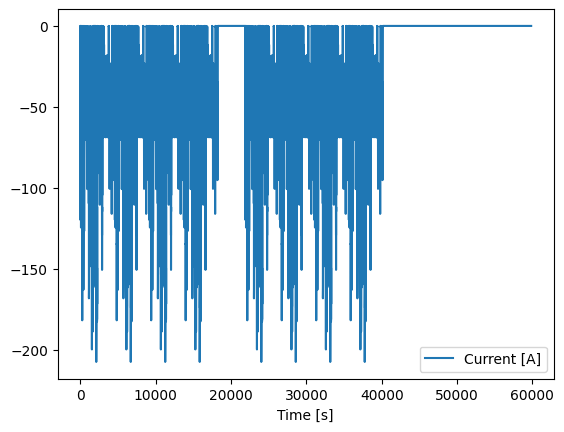

In [630]:
dischargingCycle = cycle[['Time [s]', 'Current [A]']].copy()
dischargingCycle['Current [A]'] = cycle['Current [A]'].where(cycle['Current [A]'] < 0).fillna(0)
dischargingCycle.plot('Time [s]', 'Current [A]')

<Axes: xlabel='Time [s]'>

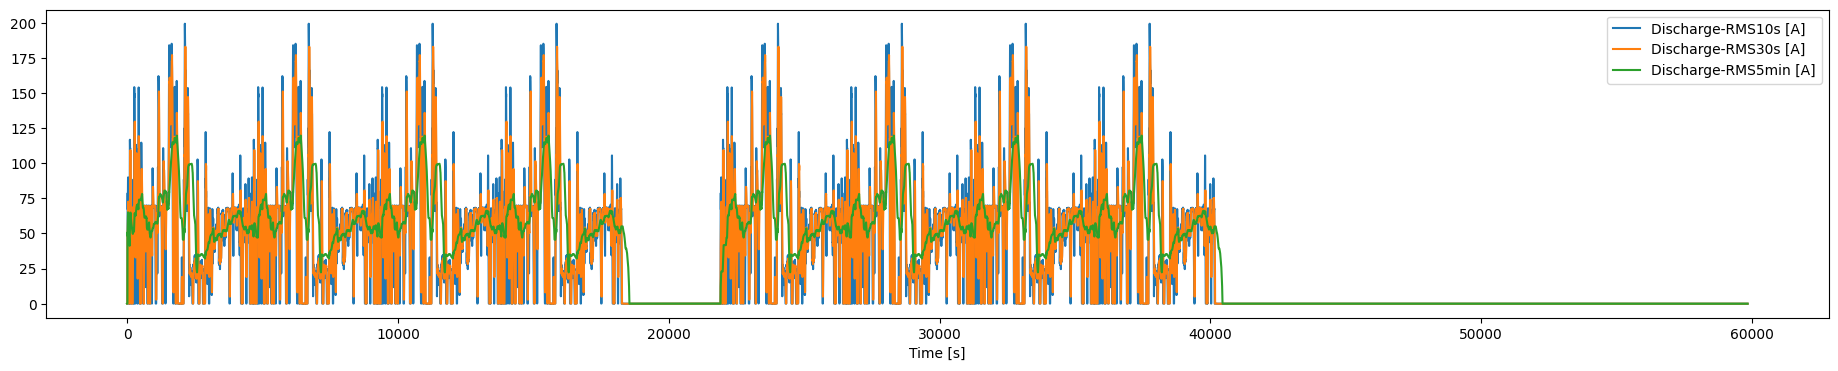

In [631]:
dischargingCycle['Discharge-RMS10s [A]'] = dischargingCycle['Current [A]'].rolling(window=10, min_periods=1).apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)
dischargingCycle['Discharge-RMS30s [A]'] = dischargingCycle['Current [A]'].rolling(window=30, min_periods=1).apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)
dischargingCycle['Discharge-RMS5min [A]'] = dischargingCycle['Current [A]'].rolling(window=300, min_periods=1).apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)
dischargingCycle['Discharge-All [A]'] = np.sqrt((dischargingCycle['Current [A]'] ** 2).mean())
dischargingCycle.plot(x='Time [s]', y=['Discharge-RMS10s [A]', 'Discharge-RMS30s [A]','Discharge-RMS5min [A]'], figsize=(23, 4))

In [632]:
maxDischargingRMS = dischargingCycle[['Discharge-RMS10s [A]','Discharge-RMS30s [A]','Discharge-RMS5min [A]','Discharge-All [A]']].max().to_frame().T
maxDischargingRMS

,Discharge-RMS10s [A],Discharge-RMS30s [A],Discharge-RMS5min [A],Discharge-All [A]
0,199.364826,182.968746,119.700887,51.280849


In [633]:
# columns = pd.MultiIndex.from_tuples([
#     ('Discharge', 'RMS10s [A]'),
#     ('Discharge', 'RMS30s [A]'),
#     ('Discharge', 'RMS5min [A]'),
#     ('Discharge', 'All [A]')
# ])
# data = dischargingCycle[['Discharge-RMS10s [A]','Discharge-RMS30s [A]','Discharge-RMS5min [A]','Discharge-All [A]']].max().to_frame().T

# maxDischargingRMS = pd.DataFrame(data= data.values, columns=columns)
# maxDischargingRMS

#Merging data for the cell analysis

In [634]:
mergedSystemParametersDataFrame = pd.concat([systemParametersDataFrame, maxDischargingRMS, maxChargingRMS], axis='columns')
mergedSystemParametersDataFrame

,Cycle usable energy EOL [kWh],Max cycle usable energy EOL [kWh],Parallel configuration,System nominal voltage [V],Discharge-RMS10s [A],Discharge-RMS30s [A],Discharge-RMS5min [A],Discharge-All [A],Charge-RMS10s [A],Charge-RMS30s [A],Charge-RMS5min [A],Charge-All [A]
0,120.156194,156.203052,NaN,650,199.364826,182.968746,119.700887,51.280849,363.953855,349.331891,188.815069,68.189376


In [635]:
listColumnsToChange = ['Cycle usable energy EOL [kWh]', 'Max cycle usable energy EOL [kWh]',
                       'Charge-RMS10s [A]','Charge-RMS30s [A]','Charge-RMS5min [A]','Charge-All [A]',
                       'Discharge-RMS10s [A]','Discharge-RMS30s [A]','Discharge-RMS5min [A]','Discharge-All [A]'
                       ]

systemConfigurationsDataframe = pd.DataFrame(columns=mergedSystemParametersDataFrame.columns)
for parallel in range(1,9):
  newRow = mergedSystemParametersDataFrame.copy()
  newRow[listColumnsToChange] = newRow[listColumnsToChange] / parallel
  newRow['Parallel configuration'] = int(parallel)
  systemConfigurationsDataframe.loc[len(systemConfigurationsDataframe)] = newRow.values[0]

systemConfigurationsDataframe.set_index('Parallel configuration', inplace=True)
systemConfigurationsDataframe

,Cycle usable energy EOL [kWh],Max cycle usable energy EOL [kWh],System nominal voltage [V],Discharge-RMS10s [A],Discharge-RMS30s [A],Discharge-RMS5min [A],Discharge-All [A],Charge-RMS10s [A],Charge-RMS30s [A],Charge-RMS5min [A],Charge-All [A]
Parallel configuration,,,,,,,,,,,
1.0,120.156194,156.203052,650.0,199.364826,182.968746,119.700887,51.280849,363.953855,349.331891,188.815069,68.189376
2.0,60.078097,78.101526,650.0,99.682413,91.484373,59.850444,25.640424,181.976927,174.665946,94.407535,34.094688
3.0,40.052065,52.067684,650.0,66.454942,60.989582,39.900296,17.093616,121.317952,116.443964,62.938356,22.729792
4.0,30.039048,39.050763,650.0,49.841207,45.742187,29.925222,12.820212,90.988464,87.332973,47.203767,17.047344
5.0,24.031239,31.240610,650.0,39.872965,36.593749,23.940177,10.256170,72.790771,69.866378,37.763014,13.637875
6.0,20.026032,26.033842,650.0,33.227471,30.494791,19.950148,8.546808,60.658976,58.221982,31.469178,11.364896
7.0,17.165171,22.314722,650.0,28.480689,26.138392,17.100127,7.325836,51.993408,49.904556,26.973581,9.741339
8.0,15.019524,19.525381,650.0,24.920603,22.871093,14.962611,6.410106,45.494232,43.666486,23.601884,8.523672


#Choosing cells

##Prepering cell database


### Import cell Database

In [636]:
data = pd.read_excel('/content/drive/My Drive/Magister/Cell_database-26-03.xlsx')
fullCellDatabase = data.copy()
fullCellDatabase.head()

,Name,Manufacturer,Cell type,Chemistry,Capacity [Ah],Nominal voltage [V],Min operating voltage [V],Max operating voltage [V],Constant discharge current [A],Constant charge current [A],RMS Discharge 30s [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm]
0,CALB 60Ah,CALB,PRISMATIC,LFP,60.0,3.2,2.5,3.65,18.0,18.0,120.0,60.0,0.8,0.8,2000.0,41.0,115.0,240.0,2.0,1.0
1,CALB 100Ah,CALB,PRISMATIC,LFP,100.0,3.2,2.5,3.65,30.0,30.0,200.0,100.0,0.8,0.8,2000.0,67.0,213.0,142.0,3.4,1.0
2,CALB 180Ah,CALB,PRISMATIC,LFP,180.0,3.2,2.5,3.65,54.0,54.0,180.0,180.0,0.8,0.8,2000.0,71.0,279.0,180.0,5.6,1.0
3,CATL 302Ah,CATL,PRISMATIC,LFP,302.0,3.2,2.5,3.65,151.0,151.0,302.0,302.0,0.8,0.8,4000.0,71.0,207.0,173.0,5.5,1.0
4,CATL 202Ah,CATL,PRISMATIC,LFP,202.0,3.2,2.5,3.65,101.0,101.0,202.0,202.0,0.8,0.8,3500.0,57.0,201.0,174.0,3.8,1.0


### Delete if no name or no capacity value

In [637]:
#Before deleting
fullCellDatabase[(fullCellDatabase['Name']).isna() | (fullCellDatabase['Capacity [Ah]'].isna()) | (fullCellDatabase['Manufacturer'].isna()) | (fullCellDatabase['Cycles'].isna())]

,Name,Manufacturer,Cell type,Chemistry,Capacity [Ah],Nominal voltage [V],Min operating voltage [V],Max operating voltage [V],Constant discharge current [A],Constant charge current [A],RMS Discharge 30s [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm]
68,GOTION 56Ah,GOTION,PRISMATIC,NMC,56.0,3.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [638]:
#after deleting
fullCellDatabase.dropna(subset=['Name', 'Capacity [Ah]', 'Manufacturer', 'Cycles'], inplace=True)
fullCellDatabase[(fullCellDatabase['Name']).isna() | (fullCellDatabase['Capacity [Ah]'].isna()) | (fullCellDatabase['Manufacturer'].isna()) | (fullCellDatabase['Cycles'].isna())]

,Name,Manufacturer,Cell type,Chemistry,Capacity [Ah],Nominal voltage [V],Min operating voltage [V],Max operating voltage [V],Constant discharge current [A],Constant charge current [A],RMS Discharge 30s [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm]


### Change duplicated names

In [639]:
fullCellDatabase[fullCellDatabase['Name'].duplicated()].head()

,Name,Manufacturer,Cell type,Chemistry,Capacity [Ah],Nominal voltage [V],Min operating voltage [V],Max operating voltage [V],Constant discharge current [A],Constant charge current [A],RMS Discharge 30s [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm]
14,EVE Energy 280Ah,EVE Energy,PRISMATIC,LFP,280.0,3.2,2.5,3.65,140.0,140.0,280.0,280.0,0.8,0.7,3500.0,72.0,205.0,174.0,5.2,1.0
28,CALB 100Ah,CALB,PRISMATIC,LFP,100.0,3.2,2.5,3.65,50.0,50.0,100.0,100.0,0.8,0.8,3000.0,15.0,160.0,116.0,2.0,1.0
31,CALB 72Ah,CALB,PRISMATIC,LFP,72.0,3.2,2.5,3.65,21.6,21.6,216.0,72.0,0.8,0.8,2000.0,30.0,68.0,216.0,1.9,1.0
40,Thunder-Sky 60Ah,Thunder-Sky,PRISMATIC,LFP,60.0,3.3,2.5,3.65,30.0,30.0,180.0,180.0,0.7,0.8,7000.0,61.0,203.0,115.0,2.1,1.0
42,Thunder-Sky 90Ah,Thunder-Sky,PRISMATIC,LFP,90.0,3.3,2.5,3.65,45.0,45.0,270.0,270.0,0.7,0.8,7000.0,61.0,218.0,143.0,2.9,1.0


In [640]:
n = 2
while not fullCellDatabase['Name'].is_unique:
  fullCellDatabase.loc[fullCellDatabase['Name'].duplicated(), 'Name'] += f' - {n}'
  n+=1
fullCellDatabase['Name'].is_unique

True

In [641]:
fullCellDatabase[fullCellDatabase['Chemistry'] == 'LFP'].tail(3)

,Name,Manufacturer,Cell type,Chemistry,Capacity [Ah],Nominal voltage [V],Min operating voltage [V],Max operating voltage [V],Constant discharge current [A],Constant charge current [A],RMS Discharge 30s [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm]
140,REPT 150Ah,REPT,PRISMATIC,LFP,150.0,NaN,2.5,3.65,150.0,75.0,300.0,225.0,NaN,0.8,3000.0,204.40,174.00,204.40,2.80,1.0
141,REPT 150Ah - 2,REPT,PRISMATIC,LFP,150.0,NaN,2.5,3.65,150.0,75.0,300.0,225.0,NaN,0.8,2500.0,145.67,174.26,145.67,2.90,1.0
142,REPT 230Ah,REPT,PRISMATIC,LFP,230.0,3.2,2.5,3.65,230.0,230.0,460.0,460.0,0.97,0.8,2000.0,54.00,204.00,174.00,4.13,1.0


### Change voltage NaN

In [642]:
fullCellDatabase.columns
NMCBasedata = {
    'Chemistry': 'NMC',
    'Nominal voltage [V]': 3.6,
    'Min operating voltage [V]': 2.8,
    'Max operating voltage [V]': 4.2,
    'DoD' : 0.8,
    'SOH EOL': 0.7
}
LFPBasedata = {
    'Chemistry': 'LFP',
    'Nominal voltage [V]': 3.2,
    'Min operating voltage [V]': 2.5,
    'Max operating voltage [V]': 3.6,
    'DoD' : 0.95,
    'SOH EOL': 0.7
}
dataToReplace = pd.DataFrame(data=[NMCBasedata, LFPBasedata]).set_index('Chemistry')
dataToReplace

,Nominal voltage [V],Min operating voltage [V],Max operating voltage [V],DoD,SOH EOL
Chemistry,,,,,
NMC,3.6,2.8,4.2,0.80,0.7
LFP,3.2,2.5,3.6,0.95,0.7


In [643]:
fullCellDatabase[(fullCellDatabase['Chemistry'] == 'NMC') & (fullCellDatabase['Nominal voltage [V]'].isna())]

,Name,Manufacturer,Cell type,Chemistry,Capacity [Ah],Nominal voltage [V],Min operating voltage [V],Max operating voltage [V],Constant discharge current [A],Constant charge current [A],RMS Discharge 30s [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm]
112,REPT 120Ah,REPT,PRISMATIC,NMC,120.0,NaN,NaN,NaN,NaN,NaN,480.0,NaN,NaN,NaN,4000.0,NaN,194.00,NaN,NaN,1.0
117,GOTION 116Ah,GOTION,PRISMATIC,NMC,116.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000.0,106.00,256.00,106.00,NaN,1.0
139,REPT 187Ah,REPT,PRISMATIC,NMC,187.0,NaN,2.8,4.4,187.0,187.0,500.0,374.0,NaN,0.75,2000.0,105.67,148.66,105.67,2.8,1.0


In [644]:
fullCellDatabase[dataToReplace.columns].isna().any()

,0
Nominal voltage [V],True
Min operating voltage [V],True
Max operating voltage [V],True
DoD,True
SOH EOL,True


In [645]:
#Uzupełnienie napięć, DoD i SOH
for index in dataToReplace.index:
  for column in dataToReplace.columns:
    fullCellDatabase.loc[(fullCellDatabase['Chemistry'] == index) & (fullCellDatabase[column].isna()), column] = dataToReplace.loc[index, column]

In [646]:
fullCellDatabase[dataToReplace.columns].isna().any()

,0
Nominal voltage [V],False
Min operating voltage [V],False
Max operating voltage [V],False
DoD,False
SOH EOL,False


### Fill charge/discharge currents NaN

In [647]:
# jest to mocne przybliżenie, jednak przy braku danych najlepsze. Założeniem jest dokładność używanej bazy danych

cRateDatabase = {
    'Constant discharge current [A]': 1,
    'Constant charge current [A]': 1,
    'RMS Discharge 30s [A]': 2.5,
    'RMS Charge 30s [A]': 2
}
cRateToReplaceCurrent = pd.DataFrame(data=[cRateDatabase])

In [648]:
indextoCheck = fullCellDatabase.loc[(fullCellDatabase['Constant discharge current [A]'].isna())].head(3).index
fullCellDatabase.iloc[indextoCheck]

,Name,Manufacturer,Cell type,Chemistry,Capacity [Ah],Nominal voltage [V],Min operating voltage [V],Max operating voltage [V],Constant discharge current [A],Constant charge current [A],RMS Discharge 30s [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm]
54,REPT 320Ah,REPT,PRISMATIC,LFP,320.0,3.20,2,3.65,NaN,NaN,NaN,NaN,0.95,0.7,8000.0,206.8,71.7,206.8,5.77,1.0
58,CATL 173Ah,CATL,PRISMATIC,LFP,173.0,3.22,2.5,3.60,NaN,NaN,NaN,NaN,0.95,0.8,3500.0,173.9,40.9,173.9,3.20,1.0
59,CATL 228Ah,CATL,PRISMATIC,LFP,228.0,3.22,2.5,3.60,NaN,NaN,NaN,NaN,0.95,0.8,3500.0,173.9,53.7,173.9,4.17,1.0


In [649]:
for column in cRateToReplaceCurrent.columns:
  fullCellDatabase.loc[(fullCellDatabase[column].isna()), column] = cRateToReplaceCurrent.loc[0, column] * fullCellDatabase['Capacity [Ah]']
fullCellDatabase.iloc[indextoCheck]

,Name,Manufacturer,Cell type,Chemistry,Capacity [Ah],Nominal voltage [V],Min operating voltage [V],Max operating voltage [V],Constant discharge current [A],Constant charge current [A],RMS Discharge 30s [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm]
54,REPT 320Ah,REPT,PRISMATIC,LFP,320.0,3.20,2,3.65,320.0,320.0,800.0,640.0,0.95,0.7,8000.0,206.8,71.7,206.8,5.77,1.0
58,CATL 173Ah,CATL,PRISMATIC,LFP,173.0,3.22,2.5,3.60,173.0,173.0,432.5,346.0,0.95,0.8,3500.0,173.9,40.9,173.9,3.20,1.0
59,CATL 228Ah,CATL,PRISMATIC,LFP,228.0,3.22,2.5,3.60,228.0,228.0,570.0,456.0,0.95,0.8,3500.0,173.9,53.7,173.9,4.17,1.0


In [650]:
columnsToCheck = ['Name', 'Manufacturer', 'Cell type', 'Chemistry',
                  'Capacity [Ah]', 'Nominal voltage [V]',
                  'Min operating voltage [V]', 'Max operating voltage [V]',
                  'Constant discharge current [A]', 'Constant charge current [A]',
                  'RMS Discharge 30s [A]', 'RMS Charge 30s [A]', 'DoD',
                  'SOH EOL', 'Cycles']
if fullCellDatabase[columnsToCheck].isna().any().any():  # Jeśli chociaż jedno NaN
    missing_cols = fullCellDatabase.isna().any()  # Seria True dla wierszy z NaN
    missing_indices = fullCellDatabase.columns[missing_cols].tolist()  # Lista indeksów
    raise ValueError(f"Some data are missing. Check columns: {missing_indices}")

##Sort dimesions - longitudinal/width/heigh

In [651]:
fullCellDatabase.iloc[[54, 58, 59]]

,Name,Manufacturer,Cell type,Chemistry,Capacity [Ah],Nominal voltage [V],Min operating voltage [V],Max operating voltage [V],Constant discharge current [A],Constant charge current [A],RMS Discharge 30s [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm]
54,REPT 320Ah,REPT,PRISMATIC,LFP,320.0,3.20,2,3.65,320.0,320.0,800.0,640.0,0.95,0.7,8000.0,206.8,71.7,206.8,5.77,1.0
58,CATL 173Ah,CATL,PRISMATIC,LFP,173.0,3.22,2.5,3.60,173.0,173.0,432.5,346.0,0.95,0.8,3500.0,173.9,40.9,173.9,3.20,1.0
59,CATL 228Ah,CATL,PRISMATIC,LFP,228.0,3.22,2.5,3.60,228.0,228.0,570.0,456.0,0.95,0.8,3500.0,173.9,53.7,173.9,4.17,1.0


In [652]:
#sorting to make length always bigger than width
mask = fullCellDatabase["Width [mm]"] > fullCellDatabase["Length [mm]"]

fullCellDatabase.loc[mask, ["Width [mm]", "Length [mm]"]] = (
    fullCellDatabase.loc[mask, ["Length [mm]", "Width [mm]"]].values
)
fullCellDatabase.iloc[[54, 58, 59]]

,Name,Manufacturer,Cell type,Chemistry,Capacity [Ah],Nominal voltage [V],Min operating voltage [V],Max operating voltage [V],Constant discharge current [A],Constant charge current [A],RMS Discharge 30s [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm]
54,REPT 320Ah,REPT,PRISMATIC,LFP,320.0,3.20,2,3.65,320.0,320.0,800.0,640.0,0.95,0.7,8000.0,71.7,206.8,206.8,5.77,1.0
58,CATL 173Ah,CATL,PRISMATIC,LFP,173.0,3.22,2.5,3.60,173.0,173.0,432.5,346.0,0.95,0.8,3500.0,40.9,173.9,173.9,3.20,1.0
59,CATL 228Ah,CATL,PRISMATIC,LFP,228.0,3.22,2.5,3.60,228.0,228.0,570.0,456.0,0.95,0.8,3500.0,53.7,173.9,173.9,4.17,1.0


## Initial cells analysis

In [653]:
columnsToAnalysis = ['Name', 'Chemistry', 'Capacity [Ah]', 'Nominal voltage [V]',
                     'Constant discharge current [A]', 'RMS Discharge 30s [A]',
                     'Constant charge current [A]', 'RMS Charge 30s [A]',
                     'DoD', 'SOH EOL', 'Cycles'
                     ]
cellDatabase = fullCellDatabase[columnsToAnalysis].copy()
cellDatabase.head(10)

,Name,Chemistry,Capacity [Ah],Nominal voltage [V],Constant discharge current [A],RMS Discharge 30s [A],Constant charge current [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles
0,CALB 60Ah,LFP,60.0,3.2,18.0,120.0,18.0,60.0,0.8,0.8,2000.0
1,CALB 100Ah,LFP,100.0,3.2,30.0,200.0,30.0,100.0,0.8,0.8,2000.0
2,CALB 180Ah,LFP,180.0,3.2,54.0,180.0,54.0,180.0,0.8,0.8,2000.0
3,CATL 302Ah,LFP,302.0,3.2,151.0,302.0,151.0,302.0,0.8,0.8,4000.0
4,CATL 202Ah,LFP,202.0,3.2,101.0,202.0,101.0,202.0,0.8,0.8,3500.0
5,COSLIGHT 150Ah,LFP,150.0,3.2,75.0,450.0,75.0,150.0,1.0,0.8,3000.0
6,ECO POWER GROUP 228Ah,LFP,228.0,3.2,76.0,456.0,76.0,228.0,0.8,0.8,2000.0
7,EVE Energy 280Ah,LFP,280.0,3.2,140.0,280.0,140.0,280.0,1.0,0.8,3500.0
8,EVE Energy 304Ah,LFP,304.0,3.2,152.0,304.0,152.0,304.0,1.0,0.8,3500.0
9,Jiangsu FREY 100Ah,LFP,100.0,3.2,50.0,200.0,50.0,100.0,1.0,0.8,2500.0


In [654]:
# cellDatabase['Cell string configuration for the system'] = np.ceil(systemConfigurationsDataframe['System nominal voltage [V]'].iloc[0] / cellDatabase['Nominal voltage [V]'])
# cellDatabase.head()

In [655]:
def AddStringConfiguration(x):
  if x == 'LFP':
    return 204
  elif x == 'NMC':
    return 180
  else:
    return np.ceil(systemConfigurationsDataframe['System nominal voltage [V]'].iloc[0] / cellDatabase['Nominal voltage [V]'])


cellDatabase['Cell string configuration for the system'] = cellDatabase['Chemistry'].apply(AddStringConfiguration)
cellDatabase.head()

,Name,Chemistry,Capacity [Ah],Nominal voltage [V],Constant discharge current [A],RMS Discharge 30s [A],Constant charge current [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles,Cell string configuration for the system
0,CALB 60Ah,LFP,60.0,3.2,18.0,120.0,18.0,60.0,0.8,0.8,2000.0,204
1,CALB 100Ah,LFP,100.0,3.2,30.0,200.0,30.0,100.0,0.8,0.8,2000.0,204
2,CALB 180Ah,LFP,180.0,3.2,54.0,180.0,54.0,180.0,0.8,0.8,2000.0,204
3,CATL 302Ah,LFP,302.0,3.2,151.0,302.0,151.0,302.0,0.8,0.8,4000.0,204
4,CATL 202Ah,LFP,202.0,3.2,101.0,202.0,101.0,202.0,0.8,0.8,3500.0,204


In [656]:
cellDatabase['Usable batterypack energy EOL [kWh]'] = cellDatabase['Capacity [Ah]'] * cellDatabase['SOH EOL'] * cellDatabase['DoD'] * systemConfigurationsDataframe['System nominal voltage [V]'].iloc[0]/ 1000
cellDatabase['Max usable batterypack energy EOL [kWh]'] = cellDatabase['Usable batterypack energy EOL [kWh]'] * 1.2
cellDatabase.head()

,Name,Chemistry,Capacity [Ah],Nominal voltage [V],Constant discharge current [A],RMS Discharge 30s [A],Constant charge current [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles,Cell string configuration for the system,Usable batterypack energy EOL [kWh],Max usable batterypack energy EOL [kWh]
0,CALB 60Ah,LFP,60.0,3.2,18.0,120.0,18.0,60.0,0.8,0.8,2000.0,204,24.960,29.9520
1,CALB 100Ah,LFP,100.0,3.2,30.0,200.0,30.0,100.0,0.8,0.8,2000.0,204,41.600,49.9200
2,CALB 180Ah,LFP,180.0,3.2,54.0,180.0,54.0,180.0,0.8,0.8,2000.0,204,74.880,89.8560
3,CATL 302Ah,LFP,302.0,3.2,151.0,302.0,151.0,302.0,0.8,0.8,4000.0,204,125.632,150.7584
4,CATL 202Ah,LFP,202.0,3.2,101.0,202.0,101.0,202.0,0.8,0.8,3500.0,204,84.032,100.8384


In [657]:
# Wybierz z cellDatabase tylko te ogniwa, które mają w takim systemie większą
# zgromadzoną energię użyteczną EOL niż wymagana, oraz maksymalną energię
# użyteczną EOL (1.2 energii obliczonej z ogniw) mniejszą, niż maksymalna
# wymagana (1.3 użytecznej energii z cyklu)

sufficientCells = pd.DataFrame()

for index in systemConfigurationsDataframe.index:
    newSufficientCells = cellDatabase[
        (cellDatabase['Usable batterypack energy EOL [kWh]'] > systemConfigurationsDataframe.loc[index, 'Cycle usable energy EOL [kWh]']) &
        (cellDatabase['Max usable batterypack energy EOL [kWh]'] < systemConfigurationsDataframe.loc[index, 'Max cycle usable energy EOL [kWh]'])
    ].copy()
    newSufficientCells['Parallel configuration'] = int(index) # musi być tak żeby zrobić multiindex
    sufficientCells = pd.concat([sufficientCells, newSufficientCells], ignore_index=True)

sufficientCells.set_index(['Parallel configuration', 'Name'], inplace=True)
sufficientCells.head()

Chemistry  Capacity [Ah]  \
Parallel configuration Name                                                
1                      CATL 302Ah                     LFP          302.0   
                       Thunder-Sky 300Ah              LFP          300.0   
                       EVE Energy 280Ah - 2 - 3       LFP          280.0   
2                      JIANGSU HIGEE 152Ah            LFP          152.0   
                       Lishen 150Ah                   LFP          150.0   

                                                 Nominal voltage [V]  \
Parallel configuration Name                                            
1                      CATL 302Ah                                3.2   
                       Thunder-Sky 300Ah                         3.3   
                       EVE Energy 280Ah - 2 - 3                  3.2   
2                      JIANGSU HIGEE 152Ah                       3.2   
                       Lishen 150Ah                              3.2   

                                                 Constant discharge current [A]  \
Parallel configuration Name                                                       
1                      CATL 302Ah                                         151.0   
                       Thunder-Sky 300Ah                                  150.0   
                       EVE Energy 280Ah - 2 - 3                           140.0   
2                      JIANGSU HIGEE 152Ah                                 76.0   
                       Lishen 150Ah                                        75.0   

                                                 RMS Discharge 30s [A]  \
Parallel configuration Name                                              
1                      CATL 302Ah                                302.0   
                       Thunder-Sky 300Ah                         900.0   
                       EVE Energy 280Ah - 2 - 3                  280.0   
2                      JIANGSU HIGEE 152Ah                       152.0   
                       Lishen 150Ah                              150.0   

                                                 Constant charge current [A]  \
Parallel configuration Name                                                    
1                      CATL 302Ah                                      151.0   
                       Thunder-Sky 300Ah                               150.0   
                       EVE Energy 280Ah - 2 - 3                        140.0   
2                      JIANGSU HIGEE 152Ah                              76.0   
                       Lishen 150Ah                                     75.0   

                                                 RMS Charge 30s [A]   DoD  \
Parallel configuration Name                                                 
1                      CATL 302Ah                             302.0  0.80   
                       Thunder-Sky 300Ah                      900.0  0.80   
                       EVE Energy 280Ah - 2 - 3               280.0  0.95   
2                      JIANGSU HIGEE 152Ah                    152.0  0.80   
                       Lishen 150Ah                           150.0  0.80   

                                                 SOH EOL  Cycles  \
Parallel configuration Name                                        
1                      CATL 302Ah                    0.8  4000.0   
                       Thunder-Sky 300Ah             0.8  5000.0   
                       EVE Energy 280Ah - 2 - 3      0.7  8000.0   
2                      JIANGSU HIGEE 152Ah           0.8  3000.0   
                       Lishen 150Ah                  0.8  3000.0   

                                                 Cell string configuration for the system  \
Parallel configuration Name                                                                 
1                      CATL 302Ah                                                     204   
                       Thunder-Sky 300Ah            

In [658]:
sufficientCells.loc[1]

,Chemistry,Capacity [Ah],Nominal voltage [V],Constant discharge current [A],RMS Discharge 30s [A],Constant charge current [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles,Cell string configuration for the system,Usable batterypack energy EOL [kWh],Max usable batterypack energy EOL [kWh]
Name,,,,,,,,,,,,,
CATL 302Ah,LFP,302.0,3.2,151.0,302.0,151.0,302.0,0.80,0.8,4000.0,204,125.632,150.7584
Thunder-Sky 300Ah,LFP,300.0,3.3,150.0,900.0,150.0,900.0,0.80,0.8,5000.0,204,124.800,149.7600
EVE Energy 280Ah - 2 - 3,LFP,280.0,3.2,140.0,280.0,140.0,280.0,0.95,0.7,8000.0,204,121.030,145.2360


## RMS Cells analysis

In [659]:
sufficientCells['Installed batterypack energy BOL [kWh]'] = sufficientCells['Nominal voltage [V]'] * sufficientCells['Cell string configuration for the system'] * sufficientCells['Capacity [Ah]'] / 1000
sufficientCells.head()

Chemistry  Capacity [Ah]  \
Parallel configuration Name                                                
1                      CATL 302Ah                     LFP          302.0   
                       Thunder-Sky 300Ah              LFP          300.0   
                       EVE Energy 280Ah - 2 - 3       LFP          280.0   
2                      JIANGSU HIGEE 152Ah            LFP          152.0   
                       Lishen 150Ah                   LFP          150.0   

                                                 Nominal voltage [V]  \
Parallel configuration Name                                            
1                      CATL 302Ah                                3.2   
                       Thunder-Sky 300Ah                         3.3   
                       EVE Energy 280Ah - 2 - 3                  3.2   
2                      JIANGSU HIGEE 152Ah                       3.2   
                       Lishen 150Ah                              3.2   

                                                 Constant discharge current [A]  \
Parallel configuration Name                                                       
1                      CATL 302Ah                                         151.0   
                       Thunder-Sky 300Ah                                  150.0   
                       EVE Energy 280Ah - 2 - 3                           140.0   
2                      JIANGSU HIGEE 152Ah                                 76.0   
                       Lishen 150Ah                                        75.0   

                                                 RMS Discharge 30s [A]  \
Parallel configuration Name                                              
1                      CATL 302Ah                                302.0   
                       Thunder-Sky 300Ah                         900.0   
                       EVE Energy 280Ah - 2 - 3                  280.0   
2                      JIANGSU HIGEE 152Ah                       152.0   
                       Lishen 150Ah                              150.0   

                                                 Constant charge current [A]  \
Parallel configuration Name                                                    
1                      CATL 302Ah                                      151.0   
                       Thunder-Sky 300Ah                               150.0   
                       EVE Energy 280Ah - 2 - 3                        140.0   
2                      JIANGSU HIGEE 152Ah                              76.0   
                       Lishen 150Ah                                     75.0   

                                                 RMS Charge 30s [A]   DoD  \
Parallel configuration Name                                                 
1                      CATL 302Ah                             302.0  0.80   
                       Thunder-Sky 300Ah                      900.0  0.80   
                       EVE Energy 280Ah - 2 - 3               280.0  0.95   
2                      JIANGSU HIGEE 152Ah                    152.0  0.80   
                       Lishen 150Ah                           150.0  0.80   

                                                 SOH EOL  Cycles  \
Parallel configuration Name                                        
1                      CATL 302Ah                    0.8  4000.0   
                       Thunder-Sky 300Ah             0.8  5000.0   
                       EVE Energy 280Ah - 2 - 3      0.7  8000.0   
2                      JIANGSU HIGEE 152Ah           0.8  3000.0   
                       Lishen 150Ah                  0.8  3000.0   

                                                 Cell string configuration for the system  \
Parallel configuration Name                                                                 
1                      CATL 302Ah                                                     204   
                       Thunder-Sky 300Ah            

In [660]:
sufficientCells[['Constant charge current [A]', 'RMS Discharge 30s [A]','Constant discharge current [A]', 'RMS Charge 30s [A]']]

Constant charge current [A]  \
Parallel configuration Name                                                    
1                      CATL 302Ah                                      151.0   
                       Thunder-Sky 300Ah                               150.0   
                       EVE Energy 280Ah - 2 - 3                        140.0   
2                      JIANGSU HIGEE 152Ah                              76.0   
                       Lishen 150Ah                                     75.0   
                       CALB 127Ah                                      127.0   
                       CALB 153Ah                                      153.0   
                       CALB 150Ah                                      150.0   
                       REPT 142Ah                                      140.0   
                       REPT 137Ah                                      137.0   
                       REPT 174Ah                                      174.0   
                       EVE Energy 125Ah                                 63.0   
3                      CALB 100Ah                                       30.0   
                       GFB 100Ah                                        50.0   
                       Sinopoly 100Ah                                   33.0   
                       CATL 100Ah                                       50.0   
                       CALB 100Ah - 2                                   50.0   
                       Thunder-Sky 100Ah                                50.0   
                       GOTION 103Ah                                    103.0   
                       CALB 100Ah - 2 - 3                              100.0   
                       GOTION 116Ah                                    116.0   
                       EVE Energy 82Ah                                  82.0   
4                      EVE Energy 75Ah                                  15.0   
                       GS Yuasa Technology 75Ah                         15.0   
5                      CALB 60Ah                                        18.0   
                       Melasta 60Ah                                     12.0   
                       EVE Energy 60Ah                                  12.0   
                       Thunder-Sky 60Ah                                 30.0   
                       EVE Energy 50Ah                                  50.0   
                       EVE Energy 50Ah - 2                              25.0   
6                      GOTION 41,5Ah                                    41.0   
                       CALB 51Ah                                        51.0   
7                      GOTION 51Ah                                      51.0   
8                      EVE Energy 32Ah                                  32.0   

                                                 RMS Discharge 30s [A]  \
Parallel configuration Name                                              
1                      CATL 302Ah                                302.0   
                       Thunder-Sky 300Ah                         900.0   
                       EVE Energy 280Ah - 2 - 3                  280.0   
2                      JIANGSU HIGEE 152Ah                       152.0   
                       Lishen 150Ah                              150.0   
                       CALB 127Ah                                317.5   
                       CALB 153Ah                                382.5   
                       CALB 150Ah                                375.0   
                       REPT 142Ah                                420.0   
                       REPT 137Ah                                342.5   
                       REPT 174Ah                                435.0   
                       EVE Energy 125Ah                          180.0   
3                      CALB 100Ah                                200.0   
                       GFB 100Ah                          

In [661]:
systemConfigurationsDataframe['Charge-All [A]']

,Charge-All [A]
Parallel configuration,
1.0,68.189376
2.0,34.094688
3.0,22.729792
4.0,17.047344
5.0,13.637875
6.0,11.364896
7.0,9.741339
8.0,8.523672


In [662]:
# ------------------------ RMS całkowity ---------------------------
rowsToStay = []

for index in sufficientCells.index.get_level_values(0).unique():
    mask = (sufficientCells['Constant charge current [A]'].loc[index] >= systemConfigurationsDataframe['Charge-All [A]'].loc[index]) & (sufficientCells['Constant discharge current [A]'].loc[index] >= systemConfigurationsDataframe['Discharge-All [A]'].loc[index])

    newRow = mask.reset_index()
    newRow['Parallel configuration'] = index
    newRow.set_index(['Parallel configuration', 'Name'], inplace=True)
    rowsToStay.append(newRow)

rowsToStay = pd.concat(rowsToStay).sort_index()

sufficientCells = sufficientCells[rowsToStay[0].values]

sufficientCells
#--------------------- inny sposób ---------------------------
# rowsToStay = pd.DataFrame()

# for index in sufficientCells.index.get_level_values(0).unique():
#   chargingCellCheck = sufficientCells['Constant charge current [A]'].loc[index] >= systemConfigurationsDataframe['Charge-All [A]'].loc[index]
#   dischargingCellCheck = sufficientCells['Constant discharge current [A]'].loc[index] >= systemConfigurationsDataframe['Discharge-All [A]'].loc[index]
#   newRow = chargingCellCheck & dischargingCellCheck
#   newRow = newRow.reset_index()
#   newRow['Parallel configuration'] = index
#   newRow.set_index(['Parallel configuration','Name'], inplace=True)
#   rowsToStay = pd.concat([newRow, rowsToStay])

# rowsToStay.sort_index(inplace=True)
# sufficientCells = sufficientCells[rowsToStay.values]
# sufficientCells.head(10)

Chemistry  Capacity [Ah]  \
Parallel configuration Name                                                
1                      CATL 302Ah                     LFP          302.0   
                       Thunder-Sky 300Ah              LFP          300.0   
                       EVE Energy 280Ah - 2 - 3       LFP          280.0   
2                      JIANGSU HIGEE 152Ah            LFP          152.0   
                       Lishen 150Ah                   LFP          150.0   
                       CALB 127Ah                     LFP          127.0   
                       CALB 153Ah                     NMC          153.0   
                       CALB 150Ah                     NMC          150.0   
                       REPT 142Ah                     LFP          142.0   
                       REPT 137Ah                     LFP          137.0   
                       REPT 174Ah                     NMC          174.0   
                       EVE Energy 125Ah               LFP          125.0   
3                      CALB 100Ah                     LFP          100.0   
                       GFB 100Ah                      LFP          100.0   
                       Sinopoly 100Ah                 LFP          100.0   
                       CATL 100Ah                     LFP          100.0   
                       CALB 100Ah - 2                 LFP          100.0   
                       Thunder-Sky 100Ah              LFP          100.0   
                       GOTION 103Ah                   NMC          103.0   
                       CALB 100Ah - 2 - 3             LFP          100.0   
                       GOTION 116Ah                   NMC          116.0   
                       EVE Energy 82Ah                LFP           82.0   
5                      CALB 60Ah                      LFP           60.0   
                       Melasta 60Ah                   LFP           60.0   
                       EVE Energy 60Ah                NMC           60.0   
                       EVE Energy 50Ah - 2            LFP           50.0   
6                      GOTION 41,5Ah                  LFP           41.5   
                       CALB 51Ah                      NMC           51.0   
7                      GOTION 51Ah                    NMC           51.0   
8                      EVE Energy 32Ah                LFP           32.0   

                                                 Nominal voltage [V]  \
Parallel configuration Name                                            
1                      CATL 302Ah                               3.20   
                       Thunder-Sky 300Ah                        3.30   
                       EVE Energy 280Ah - 2 - 3                 3.20   
2                      JIANGSU HIGEE 152Ah                      3.20   
                       Lishen 150Ah                             3.20   
                       CALB 127Ah                               3.20   
                       CALB 153Ah                               3.77   
                       CALB 150Ah                               3.76   
                       REPT 142Ah                               3.22   
                       REPT 137Ah                               3.22   
                       REPT 174Ah                               3.60   
                       EVE Energy 125Ah                         3.20   
3                      CALB 100Ah                               3.20   
                       GFB 100Ah                                3.20   
                       Sinopoly 100Ah                           3.20   
                       CATL 100Ah                               3.20   
                       CALB 100Ah - 2                           3.20   
                       Thunder-Sky 100Ah                        3.30   
                       GOTION 103Ah                             3.64   
                       CALB 100Ah - 2 - 3                       3.22   
                       GOTION 1

In [663]:
systemConfigurationsDataframe['Charge-RMS10s [A]'].head()

,Charge-RMS10s [A]
Parallel configuration,
1.0,363.953855
2.0,181.976927
3.0,121.317952
4.0,90.988464
5.0,72.790771


In [664]:
# ------------------------------ RMS 10s ----------------------------
# trzeba będzie dodać do cell database RMS10s lub RMS30s do porównania
rowsToStay = []

for index in sufficientCells.index.get_level_values(0).unique():
    mask = (sufficientCells['RMS Charge 30s [A]'].loc[index] >= systemConfigurationsDataframe['Charge-RMS30s [A]'].loc[index]) & (sufficientCells['RMS Discharge 30s [A]'].loc[index] >= systemConfigurationsDataframe['Discharge-RMS30s [A]'].loc[index])
    newRow = mask.reset_index()
    newRow['Parallel configuration'] = index
    newRow.set_index(['Parallel configuration', 'Name'], inplace=True)
    rowsToStay.append(newRow)

rowsToStay = pd.concat(rowsToStay).sort_index()

sufficientCells = sufficientCells[rowsToStay[0].values]

# Cells analysis results

In [665]:
sufficientCells

Chemistry  Capacity [Ah]  \
Parallel configuration Name                                                
1                      EVE Energy 280Ah - 2 - 3       LFP          280.0   
2                      JIANGSU HIGEE 152Ah            LFP          152.0   
                       Lishen 150Ah                   LFP          150.0   
                       CALB 127Ah                     LFP          127.0   
                       REPT 137Ah                     LFP          137.0   
                       REPT 174Ah                     NMC          174.0   
                       EVE Energy 125Ah               LFP          125.0   
3                      Sinopoly 100Ah                 LFP          100.0   
                       CALB 100Ah - 2                 LFP          100.0   
                       GOTION 103Ah                   NMC          103.0   
                       CALB 100Ah - 2 - 3             LFP          100.0   
                       GOTION 116Ah                   NMC          116.0   
                       EVE Energy 82Ah                LFP           82.0   
5                      Melasta 60Ah                   LFP           60.0   
                       EVE Energy 50Ah - 2            LFP           50.0   
6                      GOTION 41,5Ah                  LFP           41.5   
                       CALB 51Ah                      NMC           51.0   
7                      GOTION 51Ah                    NMC           51.0   
8                      EVE Energy 32Ah                LFP           32.0   

                                                 Nominal voltage [V]  \
Parallel configuration Name                                            
1                      EVE Energy 280Ah - 2 - 3                 3.20   
2                      JIANGSU HIGEE 152Ah                      3.20   
                       Lishen 150Ah                             3.20   
                       CALB 127Ah                               3.20   
                       REPT 137Ah                               3.22   
                       REPT 174Ah                               3.60   
                       EVE Energy 125Ah                         3.20   
3                      Sinopoly 100Ah                           3.20   
                       CALB 100Ah - 2                           3.20   
                       GOTION 103Ah                             3.64   
                       CALB 100Ah - 2 - 3                       3.22   
                       GOTION 116Ah                             3.60   
                       EVE Energy 82Ah                          3.20   
5                      Melasta 60Ah                             3.20   
                       EVE Energy 50Ah - 2                      3.20   
6                      GOTION 41,5Ah                            3.18   
                       CALB 51Ah                                3.70   
7                      GOTION 51Ah                              3.65   
8                      EVE Energy 32Ah                          3.20   

                                                 Constant discharge current [A]  \
Parallel configuration Name                                                       
1                      EVE Energy 280Ah - 2 - 3                           140.0   
2                      JIANGSU HIGEE 152Ah                                 76.0   
                       Lishen 150Ah                                        75.0   
                       CALB 127Ah                                         127.0   
                       REPT 137Ah                                         137.0   
                       REPT 174Ah                                         174.0   
                       EVE Energy 125Ah                                    63.0   
3                      Sinopoly 100Ah                                      33.0   
                       CALB 100Ah - 2                                      50.0   
                       GO

# Mechanical cell analysis

##Prepere database

In [666]:
fullCellDatabase.head()

,Name,Manufacturer,Cell type,Chemistry,Capacity [Ah],Nominal voltage [V],Min operating voltage [V],Max operating voltage [V],Constant discharge current [A],Constant charge current [A],RMS Discharge 30s [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm]
0,CALB 60Ah,CALB,PRISMATIC,LFP,60.0,3.2,2.5,3.65,18.0,18.0,120.0,60.0,0.8,0.8,2000.0,41.0,115.0,240.0,2.0,1.0
1,CALB 100Ah,CALB,PRISMATIC,LFP,100.0,3.2,2.5,3.65,30.0,30.0,200.0,100.0,0.8,0.8,2000.0,67.0,213.0,142.0,3.4,1.0
2,CALB 180Ah,CALB,PRISMATIC,LFP,180.0,3.2,2.5,3.65,54.0,54.0,180.0,180.0,0.8,0.8,2000.0,71.0,279.0,180.0,5.6,1.0
3,CATL 302Ah,CATL,PRISMATIC,LFP,302.0,3.2,2.5,3.65,151.0,151.0,302.0,302.0,0.8,0.8,4000.0,71.0,207.0,173.0,5.5,1.0
4,CATL 202Ah,CATL,PRISMATIC,LFP,202.0,3.2,2.5,3.65,101.0,101.0,202.0,202.0,0.8,0.8,3500.0,57.0,201.0,174.0,3.8,1.0


In [667]:
sufficientCells

Chemistry  Capacity [Ah]  \
Parallel configuration Name                                                
1                      EVE Energy 280Ah - 2 - 3       LFP          280.0   
2                      JIANGSU HIGEE 152Ah            LFP          152.0   
                       Lishen 150Ah                   LFP          150.0   
                       CALB 127Ah                     LFP          127.0   
                       REPT 137Ah                     LFP          137.0   
                       REPT 174Ah                     NMC          174.0   
                       EVE Energy 125Ah               LFP          125.0   
3                      Sinopoly 100Ah                 LFP          100.0   
                       CALB 100Ah - 2                 LFP          100.0   
                       GOTION 103Ah                   NMC          103.0   
                       CALB 100Ah - 2 - 3             LFP          100.0   
                       GOTION 116Ah                   NMC          116.0   
                       EVE Energy 82Ah                LFP           82.0   
5                      Melasta 60Ah                   LFP           60.0   
                       EVE Energy 50Ah - 2            LFP           50.0   
6                      GOTION 41,5Ah                  LFP           41.5   
                       CALB 51Ah                      NMC           51.0   
7                      GOTION 51Ah                    NMC           51.0   
8                      EVE Energy 32Ah                LFP           32.0   

                                                 Nominal voltage [V]  \
Parallel configuration Name                                            
1                      EVE Energy 280Ah - 2 - 3                 3.20   
2                      JIANGSU HIGEE 152Ah                      3.20   
                       Lishen 150Ah                             3.20   
                       CALB 127Ah                               3.20   
                       REPT 137Ah                               3.22   
                       REPT 174Ah                               3.60   
                       EVE Energy 125Ah                         3.20   
3                      Sinopoly 100Ah                           3.20   
                       CALB 100Ah - 2                           3.20   
                       GOTION 103Ah                             3.64   
                       CALB 100Ah - 2 - 3                       3.22   
                       GOTION 116Ah                             3.60   
                       EVE Energy 82Ah                          3.20   
5                      Melasta 60Ah                             3.20   
                       EVE Energy 50Ah - 2                      3.20   
6                      GOTION 41,5Ah                            3.18   
                       CALB 51Ah                                3.70   
7                      GOTION 51Ah                              3.65   
8                      EVE Energy 32Ah                          3.20   

                                                 Constant discharge current [A]  \
Parallel configuration Name                                                       
1                      EVE Energy 280Ah - 2 - 3                           140.0   
2                      JIANGSU HIGEE 152Ah                                 76.0   
                       Lishen 150Ah                                        75.0   
                       CALB 127Ah                                         127.0   
                       REPT 137Ah                                         137.0   
                       REPT 174Ah                                         174.0   
                       EVE Energy 125Ah                                    63.0   
3                      Sinopoly 100Ah                                      33.0   
                       CALB 100Ah - 2                                      50.0   
                       GO

In [668]:
fullCellDatabase.loc[fullCellDatabase['Name'].isin(sufficientCells.index.get_level_values('Name')), mechanicalCellDataList]

,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm]
12,49.0,170.0,174.0,2.900,1.0
16,37.0,208.0,174.0,2.900,1.0
20,61.0,221.0,142.0,3.100,1.0
28,15.0,160.0,116.0,2.000,1.0
32,32.0,173.0,124.0,1.400,1.0
57,120.0,290.0,120.0,1.750,1.0
67,27.0,101.0,101.0,0.875,1.0
69,28.2,118.5,118.5,0.900,1.0
75,174.4,178.0,178.0,2.450,1.0
84,118.4,160.0,118.4,1.970,1.0


In [669]:
mechanicalCellDataList = ['Width [mm]', 'Length [mm]', ' Height [mm]',
                          'Mass [kg]', 'Space between cells [mm]']

filtered_data = fullCellDatabase.set_index("Name").loc[
    sufficientCells.index.get_level_values("Name"), mechanicalCellDataList
]

mechanicalCellDatabase = pd.DataFrame(index=sufficientCells.index, data=filtered_data.values, columns=mechanicalCellDataList)

mechanicalCellDatabase['Cell string configuration for the system'] = sufficientCells['Cell string configuration for the system'].copy()
mechanicalCellDatabase['Installed batterypack energy BOL [kWh]'] = sufficientCells['Installed batterypack energy BOL [kWh]'].copy()
display(mechanicalCellDatabase)

Width [mm]  Length [mm]  \
Parallel configuration Name                                                
1                      EVE Energy 280Ah - 2 - 3       173.7        207.2   
2                      JIANGSU HIGEE 152Ah             49.0        170.0   
                       Lishen 150Ah                    37.0        208.0   
                       CALB 127Ah                     174.4        178.0   
                       REPT 137Ah                     105.2        148.6   
                       REPT 174Ah                       NaN        148.0   
                       EVE Energy 125Ah               172.0        200.7   
3                      Sinopoly 100Ah                  61.0        221.0   
                       CALB 100Ah - 2                  15.0        160.0   
                       GOTION 103Ah                   120.0        290.0   
                       CALB 100Ah - 2 - 3             118.4        160.0   
                       GOTION 116Ah                   106.0        256.0   
                       EVE Energy 82Ah                130.3        170.5   
5                      Melasta 60Ah                    32.0        173.0   
                       EVE Energy 50Ah - 2            129.8        148.3   
6                      GOTION 41,5Ah                   28.2        118.5   
                       CALB 51Ah                      101.9        148.2   
7                      GOTION 51Ah                     27.0        101.0   
8                      EVE Energy 32Ah                 94.3        148.4   

                                                  Height [mm]  Mass [kg]  \
Parallel configuration Name                                                
1                      EVE Energy 280Ah - 2 - 3         207.2      5.490   
2                      JIANGSU HIGEE 152Ah              174.0      2.900   
                       Lishen 150Ah                     174.0      2.900   
                       CALB 127Ah                       178.0      2.450   
                       REPT 137Ah                       105.2      2.600   
                       REPT 174Ah                         NaN        NaN   
                       EVE Energy 125Ah                 172.0      2.390   
3                      Sinopoly 100Ah                   142.0      3.100   
                       CALB 100Ah - 2                   116.0      2.000   
                       GOTION 103Ah                     120.0      1.750   
                       CALB 100Ah - 2 - 3               118.4      1.970   
                       GOTION 116Ah                     106.0        NaN   
                       EVE Energy 82Ah                  170.5      1.680   
5                      Melasta 60Ah                     124.0      1.400   
                       EVE Energy 50Ah - 2              129.8      1.035   
6                      GOTION 41,5Ah                    118.5      0.900   
                       CALB 51Ah                        101.9      0.870   
7                      GOTION 51Ah                      101.0      0.875   
8                      EVE Energy 32Ah                   94.3      0.730   

                                                 Space between cells [mm]  \
Parallel configuration Name                                                 
1                      EVE Energy 280Ah - 2 - 3                       1.0   
2                      JIANGSU HIGEE 152Ah                            1.0   
                       Lishen 150Ah                                   1.0   
                       CALB 127Ah                                     1.0   
                       REPT 137Ah                                     1.0   
                       REPT 174Ah                                     1.0   
                       EVE Energy 125Ah                               1.0   
3                      Sinopoly 100Ah                                 1.0   
                       CALB 100Ah - 2                                 1.0   
        

## Possible configurations

In [670]:
# proposalBatteryDimension = mechanicalCellDatabase.reset_index()[mechanicalCellDataList + ['Name', 'Parallel configuration', 'Cell string configuration for the system']].set_index('Name')
# proposalBatteryDimension
mechanicalCellDatabase.reset_index(inplace=True)
mechanicalCellDatabase.set_index('Name', inplace=True)
mechanicalCellDatabase['Parallel configuration'] = mechanicalCellDatabase.pop('Parallel configuration')

mechanicalCellDatabase

,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm],Cell string configuration for the system,Installed batterypack energy BOL [kWh],Parallel configuration
Name,,,,,,,,
EVE Energy 280Ah - 2 - 3,173.7,207.2,207.2,5.490,1.0,204,182.78400,1
JIANGSU HIGEE 152Ah,49.0,170.0,174.0,2.900,1.0,204,99.22560,2
Lishen 150Ah,37.0,208.0,174.0,2.900,1.0,204,97.92000,2
CALB 127Ah,174.4,178.0,178.0,2.450,1.0,204,82.90560,2
REPT 137Ah,105.2,148.6,105.2,2.600,1.0,204,89.99256,2
REPT 174Ah,NaN,148.0,NaN,NaN,1.0,180,112.75200,2
EVE Energy 125Ah,172.0,200.7,172.0,2.390,1.0,204,81.60000,2
Sinopoly 100Ah,61.0,221.0,142.0,3.100,1.0,204,65.28000,3
CALB 100Ah - 2,15.0,160.0,116.0,2.000,1.0,204,65.28000,3


In [671]:
def findConfigurations(number):
  dividers = []
  for n in range(1, number+1):
    if number % n == 0:
      dividers.append(n)
  longitudinalList = []
  transversalList = []
  for n in dividers:
    if n != 1 and n != 2 and n != number and n != number/2:
      longitudinalList.append(n)
      transversalList.append(int(number / n))

  return longitudinalList, transversalList

In [672]:
def analyseConfigurations(row):
  newConfigurationRows = row.reset_index().iloc[0].to_frame().T
  levels = [1, 2, 3]

  newConfigurationRows = newConfigurationRows.loc[newConfigurationRows.index.repeat(len(levels))].copy()
  newConfigurationRows['Levels'] = levels
  newConfigurationRows['Cell string configuration for the system'] = newConfigurationRows['Cell string configuration for the system'] / newConfigurationRows['Levels']

  expanded_rows = []  # Lista na nowe wiersze

  for index, row in newConfigurationRows.iterrows():
      longitudinalList, transversalList = findConfigurations(int(row['Cell string configuration for the system']))

      for longitudinal, transversal in zip(longitudinalList, transversalList):
          new_row = row.copy()
          new_row['Longitudinal cells amount'] = longitudinal
          new_row['Transversal cells amount'] = transversal
          expanded_rows.append(new_row)

  newConfigurationRows = pd.DataFrame(expanded_rows).reset_index(drop=True)

  return newConfigurationRows

In [673]:
cellConfigurationsSolution = pd.DataFrame(columns=mechanicalCellDatabase.columns)
# cellConfigurationsSolution
for index, row in mechanicalCellDatabase.iterrows():
  newConfigurations = analyseConfigurations(row.to_frame().T)
  cellConfigurationsSolution = pd.concat([cellConfigurationsSolution, newConfigurations])

cellConfigurationsSolution.head(14)

<ipython-input-673-d19b231fabf5>:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cellConfigurationsSolution = pd.concat([cellConfigurationsSolution, newConfigurations])


,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm],Cell string configuration for the system,Installed batterypack energy BOL [kWh],Parallel configuration,index,Levels,Longitudinal cells amount,Transversal cells amount
0,173.7,207.2,207.2,5.49,1.0,204.0,182.784,1.0,EVE Energy 280Ah - 2 - 3,1.0,3.0,68.0
1,173.7,207.2,207.2,5.49,1.0,204.0,182.784,1.0,EVE Energy 280Ah - 2 - 3,1.0,4.0,51.0
2,173.7,207.2,207.2,5.49,1.0,204.0,182.784,1.0,EVE Energy 280Ah - 2 - 3,1.0,6.0,34.0
3,173.7,207.2,207.2,5.49,1.0,204.0,182.784,1.0,EVE Energy 280Ah - 2 - 3,1.0,12.0,17.0
4,173.7,207.2,207.2,5.49,1.0,204.0,182.784,1.0,EVE Energy 280Ah - 2 - 3,1.0,17.0,12.0
5,173.7,207.2,207.2,5.49,1.0,204.0,182.784,1.0,EVE Energy 280Ah - 2 - 3,1.0,34.0,6.0
6,173.7,207.2,207.2,5.49,1.0,204.0,182.784,1.0,EVE Energy 280Ah - 2 - 3,1.0,51.0,4.0
7,173.7,207.2,207.2,5.49,1.0,204.0,182.784,1.0,EVE Energy 280Ah - 2 - 3,1.0,68.0,3.0
8,173.7,207.2,207.2,5.49,1.0,102.0,182.784,1.0,EVE Energy 280Ah - 2 - 3,2.0,3.0,34.0
9,173.7,207.2,207.2,5.49,1.0,102.0,182.784,1.0,EVE Energy 280Ah - 2 - 3,2.0,6.0,17.0


In [674]:
cellConfigurationsSolution.loc[:, 'Pack width [mm]'] = cellConfigurationsSolution['Transversal cells amount'] * cellConfigurationsSolution['Width [mm]']
cellConfigurationsSolution.loc[:, 'Pack length [mm]'] = cellConfigurationsSolution['Longitudinal cells amount'] * cellConfigurationsSolution['Length [mm]']

cellConfigurationsSolution.loc[:, 'Pack heigh [mm]'] = (cellConfigurationsSolution[' Height [mm]'] + 20) * cellConfigurationsSolution['Levels']
cellConfigurationsSolution.loc[:, 'Ratio'] = cellConfigurationsSolution['Pack width [mm]'] / cellConfigurationsSolution['Pack length [mm]']
# cellConfigurationsSolution.loc[:, 'PackSize'] = cellConfigurationsSolution['Pack length'] * cellConfigurationsSolution['Pack width'] + ((cellConfigurationsSolution['Transversal cells amount'] + 1) + (cellConfigurationsSolution['Longitudinal cells amount'] + 1)) * cellConfigurationsSolution['Space between cells [mm]']
cellConfigurationsSolution.loc[:,'Configuration'] = cellConfigurationsSolution.apply(lambda row: f"{int(row['Longitudinal cells amount'])} modules each {int(row['Transversal cells amount'])} cells", axis=1)
cellConfigurationsSolution.set_index(['index', 'Levels', 'Configuration'], inplace=True)
cellConfigurationsSolution.head(14)

Width [mm]  \
index                    Levels Configuration                          
EVE Energy 280Ah - 2 - 3 1.0    3 modules each 68 cells        173.7   
                                4 modules each 51 cells        173.7   
                                6 modules each 34 cells        173.7   
                                12 modules each 17 cells       173.7   
                                17 modules each 12 cells       173.7   
                                34 modules each 6 cells        173.7   
                                51 modules each 4 cells        173.7   
                                68 modules each 3 cells        173.7   
                         2.0    3 modules each 34 cells        173.7   
                                6 modules each 17 cells        173.7   
                                17 modules each 6 cells        173.7   
                                34 modules each 3 cells        173.7   
                         3.0    4 modules each 17 cells        173.7   
                                17 modules each 4 cells        173.7   

                                                          Length [mm]  \
index                    Levels Configuration                           
EVE Energy 280Ah - 2 - 3 1.0    3 modules each 68 cells         207.2   
                                4 modules each 51 cells         207.2   
                                6 modules each 34 cells         207.2   
                                12 modules each 17 cells        207.2   
                                17 modules each 12 cells        207.2   
                                34 modules each 6 cells         207.2   
                                51 modules each 4 cells         207.2   
                                68 modules each 3 cells         207.2   
                         2.0    3 modules each 34 cells         207.2   
                                6 modules each 17 cells         207.2   
                                17 modules each 6 cells         207.2   
                                34 modules each 3 cells         207.2   
                         3.0    4 modules each 17 cells         207.2   
                                17 modules each 4 cells         207.2   

                                                           Height [mm]  \
index                    Levels Configuration                            
EVE Energy 280Ah - 2 - 3 1.0    3 modules each 68 cells          207.2   
                                4 modules each 51 cells          207.2   
                                6 modules each 34 cells          207.2   
                                12 modules each 17 cells         207.2   
                                17 modules each 12 cells         207.2   
                                34 modules each 6 cells          207.2   
                                51 modules each 4 cells          207.2   
                                68 modules each 3 cells          207.2   
                         2.0    3 modules each 34 cells          207.2   
                                6 modules each 17 cells          207.2   
                                17 modules each 6 cells          207.2   
                                34 modules each 3 cells          207.2   
                         3.0    4 modules each 17 cells          207.2   
                                17 modules each 4 cells          207.2   

                                                          Mass [kg]  \
index                    Levels Configuration                         
EVE Energy 280Ah - 2 - 3 1.0    3 modules each 68 cells        5.49   
                                4 modules each 51 cells        5.49   
                                6 modules each 34 cells        5.49   
                                12 modules each 17 cells       5.49   
                                17 modules each 12 cells       5.49   
                                34 modules each 6 cell

In [675]:
#sorting to make length always bigger than width - required for the voolumetric analysis
mask = cellConfigurationsSolution["Pack width [mm]"] > cellConfigurationsSolution["Pack length [mm]"]

cellConfigurationsSolution.loc[mask, ["Pack width [mm]", "Pack length [mm]"]] = (
    cellConfigurationsSolution.loc[mask, ["Pack length [mm]", "Pack width [mm]"]].values
)
cellConfigurationsSolution.head(14)

Width [mm]  \
index                    Levels Configuration                          
EVE Energy 280Ah - 2 - 3 1.0    3 modules each 68 cells        173.7   
                                4 modules each 51 cells        173.7   
                                6 modules each 34 cells        173.7   
                                12 modules each 17 cells       173.7   
                                17 modules each 12 cells       173.7   
                                34 modules each 6 cells        173.7   
                                51 modules each 4 cells        173.7   
                                68 modules each 3 cells        173.7   
                         2.0    3 modules each 34 cells        173.7   
                                6 modules each 17 cells        173.7   
                                17 modules each 6 cells        173.7   
                                34 modules each 3 cells        173.7   
                         3.0    4 modules each 17 cells        173.7   
                                17 modules each 4 cells        173.7   

                                                          Length [mm]  \
index                    Levels Configuration                           
EVE Energy 280Ah - 2 - 3 1.0    3 modules each 68 cells         207.2   
                                4 modules each 51 cells         207.2   
                                6 modules each 34 cells         207.2   
                                12 modules each 17 cells        207.2   
                                17 modules each 12 cells        207.2   
                                34 modules each 6 cells         207.2   
                                51 modules each 4 cells         207.2   
                                68 modules each 3 cells         207.2   
                         2.0    3 modules each 34 cells         207.2   
                                6 modules each 17 cells         207.2   
                                17 modules each 6 cells         207.2   
                                34 modules each 3 cells         207.2   
                         3.0    4 modules each 17 cells         207.2   
                                17 modules each 4 cells         207.2   

                                                           Height [mm]  \
index                    Levels Configuration                            
EVE Energy 280Ah - 2 - 3 1.0    3 modules each 68 cells          207.2   
                                4 modules each 51 cells          207.2   
                                6 modules each 34 cells          207.2   
                                12 modules each 17 cells         207.2   
                                17 modules each 12 cells         207.2   
                                34 modules each 6 cells          207.2   
                                51 modules each 4 cells          207.2   
                                68 modules each 3 cells          207.2   
                         2.0    3 modules each 34 cells          207.2   
                                6 modules each 17 cells          207.2   
                                17 modules each 6 cells          207.2   
                                34 modules each 3 cells          207.2   
                         3.0    4 modules each 17 cells          207.2   
                                17 modules each 4 cells          207.2   

                                                          Mass [kg]  \
index                    Levels Configuration                         
EVE Energy 280Ah - 2 - 3 1.0    3 modules each 68 cells        5.49   
                                4 modules each 51 cells        5.49   
                                6 modules each 34 cells        5.49   
                                12 modules each 17 cells       5.49   
                                17 modules each 12 cells       5.49   
                                34 modules each 6 cell

In [676]:
#usunięcie układów, które mają błędne wymiary, na podstawie ratio szerokość/długość
cellConfigurationsSolution = cellConfigurationsSolution.loc[(cellConfigurationsSolution['Ratio'] >= 0.25) & (cellConfigurationsSolution['Ratio'] <= 6), :].copy()
cellConfigurationsSolution.head(10)

Width [mm]  \
index                    Levels Configuration                          
EVE Energy 280Ah - 2 - 3 1.0    6 modules each 34 cells        173.7   
                                12 modules each 17 cells       173.7   
                                17 modules each 12 cells       173.7   
                         2.0    6 modules each 17 cells        173.7   
                                17 modules each 6 cells        173.7   
                         3.0    4 modules each 17 cells        173.7   
JIANGSU HIGEE 152Ah      1.0    4 modules each 51 cells         49.0   
                                6 modules each 34 cells         49.0   
                                12 modules each 17 cells        49.0   
                         2.0    3 modules each 34 cells         49.0   

                                                          Length [mm]  \
index                    Levels Configuration                           
EVE Energy 280Ah - 2 - 3 1.0    6 modules each 34 cells         207.2   
                                12 modules each 17 cells        207.2   
                                17 modules each 12 cells        207.2   
                         2.0    6 modules each 17 cells         207.2   
                                17 modules each 6 cells         207.2   
                         3.0    4 modules each 17 cells         207.2   
JIANGSU HIGEE 152Ah      1.0    4 modules each 51 cells         170.0   
                                6 modules each 34 cells         170.0   
                                12 modules each 17 cells        170.0   
                         2.0    3 modules each 34 cells         170.0   

                                                           Height [mm]  \
index                    Levels Configuration                            
EVE Energy 280Ah - 2 - 3 1.0    6 modules each 34 cells          207.2   
                                12 modules each 17 cells         207.2   
                                17 modules each 12 cells         207.2   
                         2.0    6 modules each 17 cells          207.2   
                                17 modules each 6 cells          207.2   
                         3.0    4 modules each 17 cells          207.2   
JIANGSU HIGEE 152Ah      1.0    4 modules each 51 cells          174.0   
                                6 modules each 34 cells          174.0   
                                12 modules each 17 cells         174.0   
                         2.0    3 modules each 34 cells          174.0   

                                                          Mass [kg]  \
index                    Levels Configuration                         
EVE Energy 280Ah - 2 - 3 1.0    6 modules each 34 cells        5.49   
                                12 modules each 17 cells       5.49   
                                17 modules each 12 cells       5.49   
                         2.0    6 modules each 17 cells        5.49   
                                17 modules each 6 cells        5.49   
                         3.0    4 modules each 17 cells        5.49   
JIANGSU HIGEE 152Ah      1.0    4 modules each 51 cells        2.90   
                                6 modules each 34 cells        2.90   
                                12 modules each 17 cells       2.90   
                         2.0    3 modules each 34 cells        2.90   

                                                          Space between cells [mm]  \
index                    Levels Configuration                                        
EVE Energy 280Ah - 2 - 3 1.0    6 modules each 34 cells                        1.0   
                                12 modules each 17 cells                       1.0   
                                17 modules each 12 cells                       1.0   
                         2.0    6 modules each 17 cells                        1.0   
                                17 modules each 6 cells   

##System energy density - gravimetric/volumetric

###Volumetric density [Wh/m3]

In [677]:
#assuption:
#         - width + 2x30mm (for side walls)
#         - length + 200mm (frontwall, electronic devices, connectors plate) + 20mm (Reare wall)
#         - height - already added 20 mm for the cooling plate and the connectors and gap
cellConfigurationsSolution['System volumetric density [kWh/m3]'] = cellConfigurationsSolution['Installed batterypack energy BOL [kWh]']/(
    (cellConfigurationsSolution['Pack length [mm]'] + (200/cellConfigurationsSolution.index.get_level_values('Levels') + 20)) *
    (cellConfigurationsSolution['Pack width [mm]'] + 30 * 2) *
    cellConfigurationsSolution['Pack heigh [mm]'] * pow(10, -9) *
    cellConfigurationsSolution.index.get_level_values('Levels'))

cellConfigurationsSolution.head(10)

Width [mm]  \
index                    Levels Configuration                          
EVE Energy 280Ah - 2 - 3 1.0    6 modules each 34 cells        173.7   
                                12 modules each 17 cells       173.7   
                                17 modules each 12 cells       173.7   
                         2.0    6 modules each 17 cells        173.7   
                                17 modules each 6 cells        173.7   
                         3.0    4 modules each 17 cells        173.7   
JIANGSU HIGEE 152Ah      1.0    4 modules each 51 cells         49.0   
                                6 modules each 34 cells         49.0   
                                12 modules each 17 cells        49.0   
                         2.0    3 modules each 34 cells         49.0   

                                                          Length [mm]  \
index                    Levels Configuration                           
EVE Energy 280Ah - 2 - 3 1.0    6 modules each 34 cells         207.2   
                                12 modules each 17 cells        207.2   
                                17 modules each 12 cells        207.2   
                         2.0    6 modules each 17 cells         207.2   
                                17 modules each 6 cells         207.2   
                         3.0    4 modules each 17 cells         207.2   
JIANGSU HIGEE 152Ah      1.0    4 modules each 51 cells         170.0   
                                6 modules each 34 cells         170.0   
                                12 modules each 17 cells        170.0   
                         2.0    3 modules each 34 cells         170.0   

                                                           Height [mm]  \
index                    Levels Configuration                            
EVE Energy 280Ah - 2 - 3 1.0    6 modules each 34 cells          207.2   
                                12 modules each 17 cells         207.2   
                                17 modules each 12 cells         207.2   
                         2.0    6 modules each 17 cells          207.2   
                                17 modules each 6 cells          207.2   
                         3.0    4 modules each 17 cells          207.2   
JIANGSU HIGEE 152Ah      1.0    4 modules each 51 cells          174.0   
                                6 modules each 34 cells          174.0   
                                12 modules each 17 cells         174.0   
                         2.0    3 modules each 34 cells          174.0   

                                                          Mass [kg]  \
index                    Levels Configuration                         
EVE Energy 280Ah - 2 - 3 1.0    6 modules each 34 cells        5.49   
                                12 modules each 17 cells       5.49   
                                17 modules each 12 cells       5.49   
                         2.0    6 modules each 17 cells        5.49   
                                17 modules each 6 cells        5.49   
                         3.0    4 modules each 17 cells        5.49   
JIANGSU HIGEE 152Ah      1.0    4 modules each 51 cells        2.90   
                                6 modules each 34 cells        2.90   
                                12 modules each 17 cells       2.90   
                         2.0    3 modules each 34 cells        2.90   

                                                          Space between cells [mm]  \
index                    Levels Configuration                                        
EVE Energy 280Ah - 2 - 3 1.0    6 modules each 34 cells                        1.0   
                                12 modules each 17 cells                       1.0   
                                17 modules each 12 cells                       1.0   
                         2.0    6 modules each 17 cells                        1.0   
                                17 modules each 6 cells   

In [678]:
89.99256/((1377.0+220)*(404.0+60)*121.0*1*2*pow(10, -9))

501.8435464187

## Gravimetric density [Wh/kg]

In [679]:
cellConfigurationsSolution[cellConfigurationsSolution['Mass [kg]'].isna()]

Width [mm]  Length [mm]  \
index        Levels Configuration                                       
GOTION 116Ah 1.0    4 modules each 45 cells        106.0        256.0   
                    5 modules each 36 cells        106.0        256.0   
                    6 modules each 30 cells        106.0        256.0   
                    9 modules each 20 cells        106.0        256.0   
                    10 modules each 18 cells       106.0        256.0   
                    12 modules each 15 cells       106.0        256.0   
                    15 modules each 12 cells       106.0        256.0   
             2.0    3 modules each 30 cells        106.0        256.0   
                    5 modules each 18 cells        106.0        256.0   
                    6 modules each 15 cells        106.0        256.0   
                    9 modules each 10 cells        106.0        256.0   
                    10 modules each 9 cells        106.0        256.0   
             3.0    3 modules each 20 cells        106.0        256.0   
                    4 modules each 15 cells        106.0        256.0   
                    5 modules each 12 cells        106.0        256.0   
                    6 modules each 10 cells        106.0        256.0   

                                               Height [mm]  Mass [kg]  \
index        Levels Configuration                                       
GOTION 116Ah 1.0    4 modules each 45 cells          106.0        NaN   
                    5 modules each 36 cells          106.0        NaN   
                    6 modules each 30 cells          106.0        NaN   
                    9 modules each 20 cells          106.0        NaN   
                    10 modules each 18 cells         106.0        NaN   
                    12 modules each 15 cells         106.0        NaN   
                    15 modules each 12 cells         106.0        NaN   
             2.0    3 modules each 30 cells          106.0        NaN   
                    5 modules each 18 cells          106.0        NaN   
                    6 modules each 15 cells          106.0        NaN   
                    9 modules each 10 cells          106.0        NaN   
                    10 modules each 9 cells          106.0        NaN   
             3.0    3 modules each 20 cells          106.0        NaN   
                    4 modules each 15 cells          106.0        NaN   
                    5 modules each 12 cells          106.0        NaN   
                    6 modules each 10 cells          106.0        NaN   

                                              Space between cells [mm]  \
index        Levels Configuration                                        
GOTION 116Ah 1.0    4 modules each 45 cells                        1.0   
                    5 modules each 36 cells                        1.0   
                    6 modules each 30 cells                        1.0   
                    9 modules each 20 cells                        1.0   
                    10 modules each 18 cells                       1.0   
                    12 modules each 15 cells                       1.0   
                    15 modules each 12 cells                       1.0   
             2.0    3 modules each 30 cells                        1.0   
                    5 modules each 18 cells                        1.0   
                    6 modules each 15 cells                        1.0   
                    9 modules each 10 cells                        1.0   
                    10 modules each 9 cells                        1.0   
             3.0    3 modules each 20 cells                        1.0   
                    4 modules each 15 cells                        1.0   
                    5 modules each 12 cells                        1.0   
                    6 modules each 10 cells                        1.0   

                                              Cell string configuration for the sys

In [692]:
#assumed electrical device mass - 15 kg, aluminium frame - 35kg = +40 kg
cellConfigurationsSolution['System gravimetric density [Wh/kg]'] = cellConfigurationsSolution['Installed batterypack energy BOL [kWh]'] * 1000 / (
    cellConfigurationsSolution['Mass [kg]'] * cellConfigurationsSolution['Cell string configuration for the system'] * cellConfigurationsSolution.index.get_level_values('Levels') + 50)
cellConfigurationsSolution.head(20)

Width [mm]  \
index                    Levels Configuration                          
EVE Energy 280Ah - 2 - 3 1.0    6 modules each 34 cells        173.7   
                                12 modules each 17 cells       173.7   
                                17 modules each 12 cells       173.7   
                         2.0    6 modules each 17 cells        173.7   
                                17 modules each 6 cells        173.7   
                         3.0    4 modules each 17 cells        173.7   
JIANGSU HIGEE 152Ah      1.0    4 modules each 51 cells         49.0   
                                6 modules each 34 cells         49.0   
                                12 modules each 17 cells        49.0   
                         2.0    3 modules each 34 cells         49.0   
                                6 modules each 17 cells         49.0   
                         3.0    4 modules each 17 cells         49.0   
Lishen 150Ah             1.0    3 modules each 68 cells         37.0   
                                4 modules each 51 cells         37.0   
                                6 modules each 34 cells         37.0   
                                12 modules each 17 cells        37.0   
                         2.0    3 modules each 34 cells         37.0   
                                6 modules each 17 cells         37.0   
                         3.0    4 modules each 17 cells         37.0   
CALB 127Ah               1.0    6 modules each 34 cells        174.4   

                                                          Length [mm]  \
index                    Levels Configuration                           
EVE Energy 280Ah - 2 - 3 1.0    6 modules each 34 cells         207.2   
                                12 modules each 17 cells        207.2   
                                17 modules each 12 cells        207.2   
                         2.0    6 modules each 17 cells         207.2   
                                17 modules each 6 cells         207.2   
                         3.0    4 modules each 17 cells         207.2   
JIANGSU HIGEE 152Ah      1.0    4 modules each 51 cells         170.0   
                                6 modules each 34 cells         170.0   
                                12 modules each 17 cells        170.0   
                         2.0    3 modules each 34 cells         170.0   
                                6 modules each 17 cells         170.0   
                         3.0    4 modules each 17 cells         170.0   
Lishen 150Ah             1.0    3 modules each 68 cells         208.0   
                                4 modules each 51 cells         208.0   
                                6 modules each 34 cells         208.0   
                                12 modules each 17 cells        208.0   
                         2.0    3 modules each 34 cells         208.0   
                                6 modules each 17 cells         208.0   
                         3.0    4 modules each 17 cells         208.0   
CALB 127Ah               1.0    6 modules each 34 cells         178.0   

                                                           Height [mm]  \
index                    Levels Configuration                            
EVE Energy 280Ah - 2 - 3 1.0    6 modules each 34 cells          207.2   
                                12 modules each 17 cells         207.2   
                                17 modules each 12 cells         207.2   
                         2.0    6 modules each 17 cells          207.2   
                                17 modules each 6 cells          207.2   
                         3.0    4 modules each 17 cells          207.2   
JIANGSU HIGEE 152Ah      1.0    4 modules each 51 cells          174.0   
                                6 modules each 34 cells          174.0   
                                12 modules each 17 cells         174.0   
                         2.0    3 modules each 34 ce

##Printing the schemes

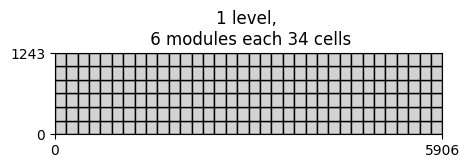

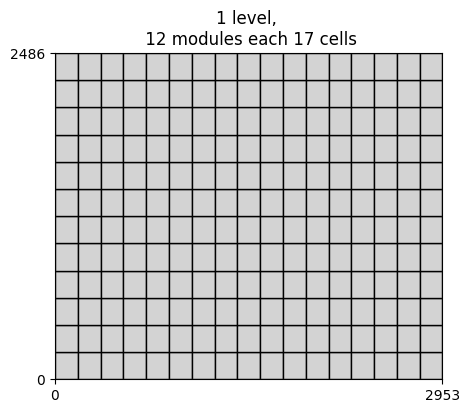

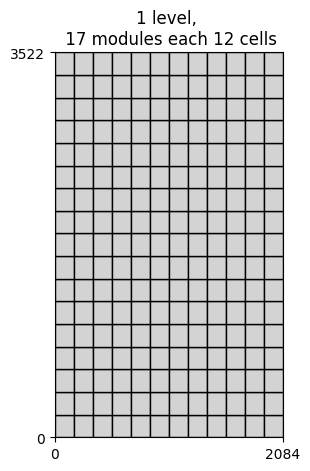

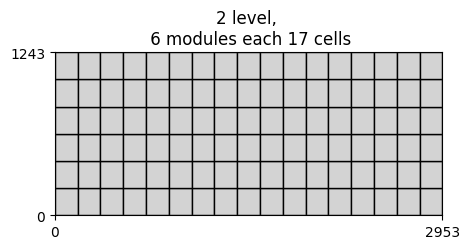

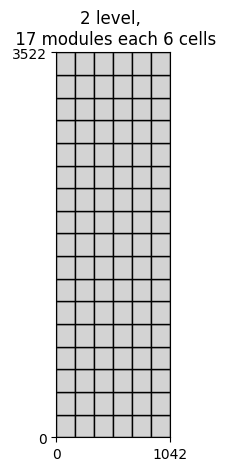

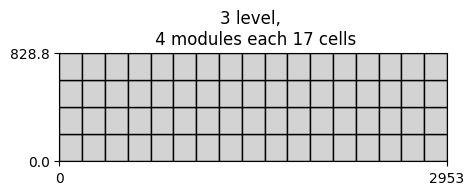

In [681]:
# Printing the schemes

for index, row in cellConfigurationsSolution.loc['EVE Energy 280Ah - 2 - 3'].iterrows():

    fig, ax = plt.subplots(figsize=(5, 5))
    for i in range(int(row['Transversal cells amount'])):
        for j in range(int(row['Longitudinal cells amount'])):
            ax.add_patch(plt.Rectangle((i * row['Width [mm]'], j * row['Length [mm]']),
                                       row['Width [mm]'], row['Length [mm]'],
                                       edgecolor='black', facecolor='lightgray'))
    ax.set_title(f"{int(index[0])} level, \n {index[1]}")
    ax.set_xlim(0, row['Transversal cells amount'] * row['Width [mm]'])
    ax.set_ylim(0, row['Longitudinal cells amount'] * row['Length [mm]'])

    ax.set_xticks([0, row['Transversal cells amount'] * row['Width [mm]']])
    ax.set_yticks([0, row['Longitudinal cells amount'] * row['Length [mm]']])
    ax.set_aspect("equal")
    ax.grid(True)
    plt.show()